# PRI Project

## Data Processing

Write something about the project here.

In [19]:
import pandas as pd
import re

Write something about data 1 here

In [20]:
# Read data 1 csv and drop the unnecessary data
jobs_data_1 = pd.read_csv('data/allJobs.csv')
jobs_data_1.drop(columns=['Date-Posted'],inplace=True)
jobs_data_1.dropna()
jobs_data_1.rename(columns = {'Company':'company','Job-Title':'title','Job-Type':'work-type','Salary':'salary','Location':'location','Description':'description'}, inplace = True)
jobs_data_1.head()

,title,company,work-type,salary,location,description
0,"Bachelor of Science, Nursing Instructor Part...",Red Deer College,Full-time,NaN,"Red Deer, AB",Position Information\n\nPosition Title\n\nBach...
1,PHD Graduate Student,IDOBE Research Group,Full-time,NaN,"Edmonton, AB",The IDOBE (Intelligent Design & Operation for ...
2,Central Graduate Advisor,University of Alberta,Full-time,"$47,210–$63,741 a year","Edmonton, AB",FGSR Grad Studies & Rsrch Admi\n\nCompetition ...
3,Student/Graduate Application,Eagle Builders LP,Internship,NaN,"Blackfalds, AB",Eagle Builders welcomes and offers work experi...
4,"Advisor, Graduate Student Experience, Haskayne...",University of Calgary,Full-time,NaN,"Calgary, AB",University of Calgary\nRSS Jump to Headline Ho...


Write something about data 2 hera

In [21]:
# Read data 2 csv and drop the unnecessary data
jobs_data_2 = pd.read_csv('data/job_postings.csv')
jobs_data_2.drop(columns=['max_salary','min_salary','job_id','expiry','closed_time','applies','currency','compensation_type','original_listed_time','remote_allowed','views','job_posting_url','application_url','application_type','formatted_experience_level','skills_desc','listed_time','posting_domain','sponsored','work_type'],inplace=True)
jobs_data_2.rename(columns = {'med_salary':'salary','formatted_work_type':'work-type'}, inplace = True)
jobs_data_2.head()

,company_id,title,description,salary,pay_period,work-type,location
0,NaN,Licensed Insurance Agent,While many industries were hurt by the last fe...,NaN,YEARLY,Full-time,"Chico, CA"
1,77766802.0,Sales Manager,Are you a dynamic and creative marketing profe...,NaN,NaN,Full-time,"Santa Clarita, CA"
2,1089558.0,Model Risk Auditor,Join Us as a Model Risk Auditor – Showcase You...,NaN,NaN,Contract,"New York, NY"
3,96654609.0,Business Manager,Business ManagerFirst Baptist Church ForneyFor...,NaN,NaN,Full-time,"Forney, TX"
4,1244539.0,NY Studio Assistant,YOU COULD BE ONE OF THE MAGIC MAKERS\nKen Fulk...,NaN,NaN,Full-time,"New York, NY"


Write something about the salary in jobs_data_1 here

In [22]:
def extract_salary_and_pay_period(salary_string):
    salary_string = str(salary_string)
    if 'a year' in salary_string:
        pay_period = 'YEARLY'
        match = re.search(r'\$([\d,.]+[kK]?)-?([\d,.]+[kK]?)?', salary_string)
        if match:
            low_value = match.group(1).replace('.', '').replace(',', '').replace('k', '000').replace('K', '000')
            high_value = match.group(2).replace('.', '').replace(',', '').replace('k', '000').replace('K', '000') if match.group(2) else low_value
            salary = (float(low_value) + float(high_value)) / 2
        else:
            match = re.search(r'\$([\d,.]+[kK]?)', salary_string)
            if match:
                salary = float(match.group(1).replace('.', '').replace(',', '').replace('k', '000').replace('K', '000'))
            else:
                salary = None
    elif 'a month' in salary_string:
        pay_period = 'MONTHLY'
        match = re.findall(r'\$([\d,.]+[kK]?)', salary_string)
        if match:
            salary_range = [(float(m.replace('.', '').replace(',', '').replace('k', '000').replace('K', '000'))) for m in match]
            salary = sum(salary_range) / len(salary_range)
        else:
            salary = None
    elif 'an hour' in salary_string:
        pay_period = 'HOURLY'
        match = re.search(r'\$([\d,.]+[kK]?)', salary_string)
        if match:
            salary = float(match.group(1).replace('.', '').replace(',', '').replace('k', '000').replace('K', '000'))
        else:
            salary = None
    else:
        pay_period = None
        salary = None
    return salary, pay_period

... apply the function

In [23]:
# Split the salary collumn into salary and pay period
jobs_data_1['salary'], jobs_data_1['pay_period'] = zip(*jobs_data_1['salary'].apply(extract_salary_and_pay_period))
# Remove outliers 
jobs_data_1 = pd.concat([jobs_data_1[jobs_data_1['salary'] < 1000000], jobs_data_1[jobs_data_1['salary'].isnull()]])
jobs_data_1.head()

,title,company,work-type,salary,location,description,pay_period
2,Central Graduate Advisor,University of Alberta,Full-time,47210.0,"Edmonton, AB",FGSR Grad Studies & Rsrch Admi\n\nCompetition ...,YEARLY
6,Post-doctoral Fellow,University of Alberta,Full-time,50000.0,"Edmonton, AB",ART East Asian Studies\n\nCompetition No. -\nA...,YEARLY
7,Graduate Research Assistant,University of Calgary,Full-time,20000.0,"Calgary, AB",The Adaptive Bionics Lab at the University of ...,YEARLY
24,Postdoctoral Fellow in Environmental Epidemiology,University of Alberta,Full-time,50000.0,"Edmonton, AB",PH School of Public Health\n\nCompetition No. ...,YEARLY
78,"Advisor, Student Service Centre",University of Alberta,Full-time,51055.0,"Edmonton, AB",RO Student Service Centre\n\nCompetition No. -...,YEARLY


.. add company data

In [24]:
# Create a new dataframe for company data
company_data_1 = jobs_data_1["company"].drop_duplicates().reset_index(drop=True).reset_index()
company_data_1.columns = ['company_id', 'company']
company_data_1['company_id'] = company_data_1['company_id'] + 3700152515

jobs_data_1 = pd.merge(jobs_data_1, company_data_1, on='company', how='left')
jobs_data_1.drop(columns=['company'],inplace=True)
jobs_data_1['work-type'].replace({'Contractor': 'Contract'}, inplace=True)

company_data_2 = pd.read_csv('data/companies.csv')
company_data_2.drop(columns=['description',	'company_size',	'state'	,'country'	,'city',	'zip_code',	'address',	'url'],inplace=True)
company_data_2.rename(columns = {'name':'company'}, inplace = True)

company_data = pd.concat([company_data_1,company_data_2])
company_data

,company_id,company
0,3700152515,University of Alberta
1,3700152516,University of Calgary
2,3700152517,University of Newcastle
3,3700152518,State Government of WA Department of Education
4,3700152519,Queensland Government - Department of Education
...,...,...
6058,3700144594,BYREDO
6059,3700144710,"Pros2Plan, a division of Spinnaker SCA"
6060,3700147810,Ascendo Resources
6061,3700150295,The Crox Group


...merge dataframes

In [25]:
# Merge dataframes
jobs_data = pd.concat([jobs_data_1, jobs_data_2], ignore_index=True)
jobs_data.head()

,title,work-type,salary,location,description,pay_period,company_id
0,Central Graduate Advisor,Full-time,47210.0,"Edmonton, AB",FGSR Grad Studies & Rsrch Admi\n\nCompetition ...,YEARLY,3.700153e+09
1,Post-doctoral Fellow,Full-time,50000.0,"Edmonton, AB",ART East Asian Studies\n\nCompetition No. -\nA...,YEARLY,3.700153e+09
2,Graduate Research Assistant,Full-time,20000.0,"Calgary, AB",The Adaptive Bionics Lab at the University of ...,YEARLY,3.700153e+09
3,Postdoctoral Fellow in Environmental Epidemiology,Full-time,50000.0,"Edmonton, AB",PH School of Public Health\n\nCompetition No. ...,YEARLY,3.700153e+09
4,"Advisor, Student Service Centre",Full-time,51055.0,"Edmonton, AB",RO Student Service Centre\n\nCompetition No. -...,YEARLY,3.700153e+09


... write something about country data

In [26]:
# Read countries csv and drop the unnecessary data
countries_data = pd.read_csv('data/countries.csv')
countries_data = countries_data[['name','alpha-2','region','sub-region']]
countries_data.head()

,name,alpha-2,region,sub-region
0,Afghanistan,AF,Asia,Southern Asia
1,Åland Islands,AX,Europe,Northern Europe
2,Albania,AL,Europe,Southern Europe
3,Algeria,DZ,Africa,Northern Africa
4,American Samoa,AS,Oceania,Polynesia


... extract city and country data

In [27]:
def extract_city_and_country(location_string, country_list):
    splited_location = location_string.split(',')
    first_word = splited_location[0]
    last_word = splited_location[-1][1:]
    country_names = country_list['name'].values
    country_alpha = country_list['alpha-2'].values

    if first_word in country_names:
        region = country_list[country_list['name'] == first_word]['region'].iloc[0]
        return None, first_word, region
    elif first_word in country_alpha:
        country = country_list[country_list['alpha-2'] == first_word]['name'].iloc[0]
        region = country_list[country_list['alpha-2'] == first_word]['region'].iloc[0]
        return None, country, region
    elif last_word in country_names:
        region = country_list[country_list['name'] == last_word]['region'].iloc[0]
        return first_word, last_word, region
    elif last_word in country_alpha:
        country = country_list[country_list['alpha-2'] == last_word]['name'].iloc[0]
        region = country_list[country_list['alpha-2'] == last_word]['region'].iloc[0]
        return first_word, country, region
    elif len(splited_location) > 0:
        return first_word, 'United States of America', 'Americas'
    return None, None, None

... aply function

In [28]:
# Create location table
jobs_location_data = pd.DataFrame(jobs_data['location'], columns=['location'])
jobs_location_data['city'], jobs_location_data['country'], jobs_location_data['region'] = zip(*jobs_location_data['location'].apply(lambda x: extract_city_and_country(x, countries_data)))
jobs_location_data.drop_duplicates(inplace=True)
jobs_location_data.reset_index(drop=True, inplace=True)
jobs_location_data.insert(0, 'location_id', range(1, 1 + len(jobs_location_data)))

jobs_data = pd.merge(jobs_data, jobs_location_data[['location', 'location_id']], on='location', how='left')
jobs_data.drop(columns=['location'], inplace=True)

jobs_location_data.drop(columns=['location'], inplace=True)
jobs_data.head()

,title,work-type,salary,description,pay_period,company_id,location_id
0,Central Graduate Advisor,Full-time,47210.0,FGSR Grad Studies & Rsrch Admi\n\nCompetition ...,YEARLY,3.700153e+09,1
1,Post-doctoral Fellow,Full-time,50000.0,ART East Asian Studies\n\nCompetition No. -\nA...,YEARLY,3.700153e+09,1
2,Graduate Research Assistant,Full-time,20000.0,The Adaptive Bionics Lab at the University of ...,YEARLY,3.700153e+09,2
3,Postdoctoral Fellow in Environmental Epidemiology,Full-time,50000.0,PH School of Public Health\n\nCompetition No. ...,YEARLY,3.700153e+09,1
4,"Advisor, Student Service Centre",Full-time,51055.0,RO Student Service Centre\n\nCompetition No. -...,YEARLY,3.700153e+09,1


... graphic 8K HDR 

Text(0.5, 1.0, 'Job postings by Pay-Period')

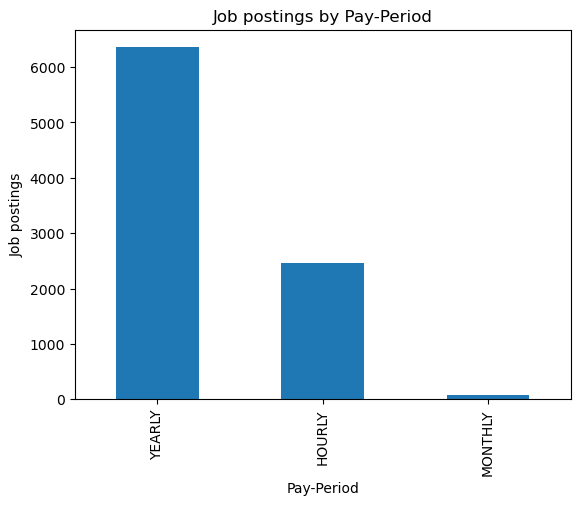

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

jobs_data['pay_period'].value_counts().plot(kind='bar')
plt.xlabel('Pay-Period')
plt.ylabel('Job postings')
plt.title('Job postings by Pay-Period')

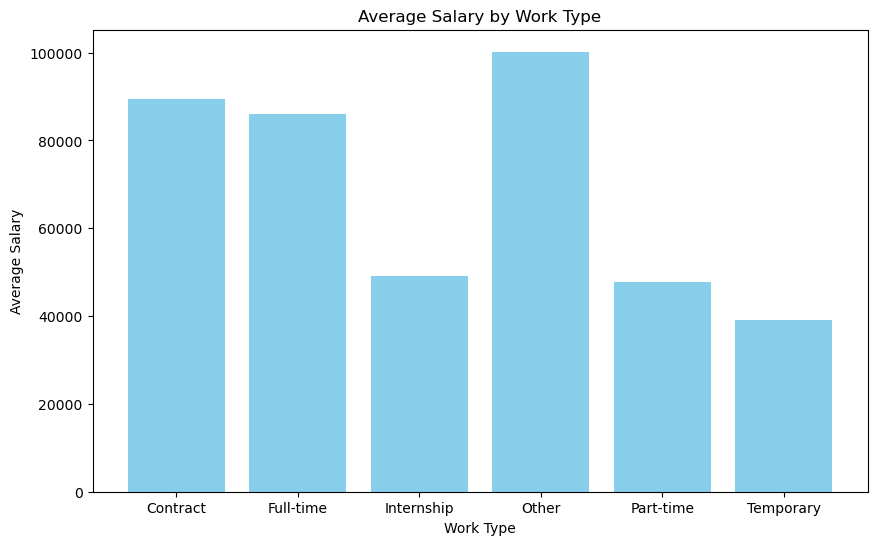

In [30]:
jobs_data_final_copy = jobs_data.copy().reset_index()

for idx ,job in jobs_data_final_copy.iterrows():
    if job["pay_period"] == "MONTHLY":
        jobs_data_final_copy.at[idx ,"salary"] *= 12
    elif job["pay_period"] == "HOURLY":
        jobs_data_final_copy.at[idx ,"salary"] *= 1810

average_salary_by_work_type = jobs_data_final_copy.groupby('work-type')['salary'].mean().reset_index()
plt.figure(figsize=(10 ,6))  
plt.bar(average_salary_by_work_type["work-type"] ,average_salary_by_work_type["salary"] ,color='skyblue')
plt.xlabel('Work Type')
plt.ylabel('Average Salary')
plt.title('Average Salary by Work Type')
plt.show()

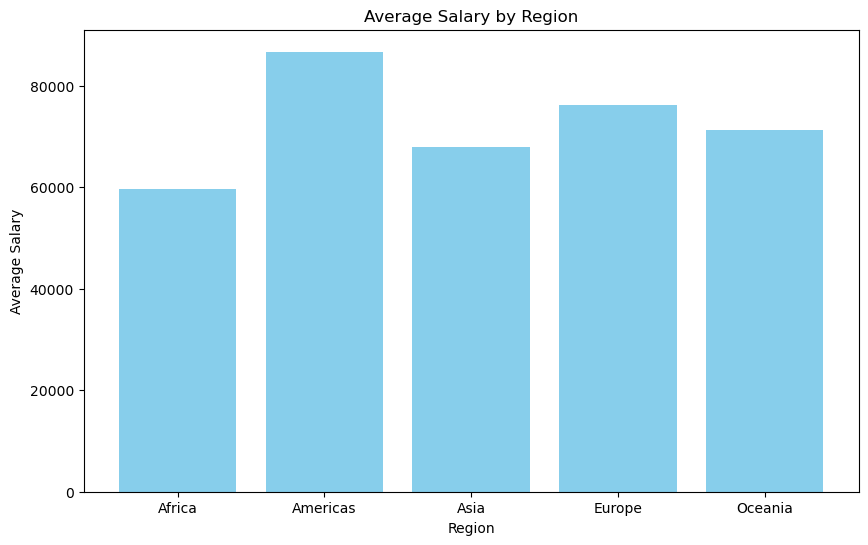

In [31]:
jobs_data_final_copy = pd.merge(jobs_data_final_copy, jobs_location_data, on='location_id', how='left')
average_salary_by_region = jobs_data_final_copy.groupby('region')['salary'].mean().reset_index()
plt.figure(figsize=(10 ,6))
plt.bar(average_salary_by_region["region"] ,average_salary_by_region["salary"] ,color='skyblue')
plt.xlabel('Region')
plt.ylabel('Average Salary')
plt.title('Average Salary by Region')
plt.show()

,index,title,work-type,salary,description,pay_period,company_id,location_id,city,country,region
0,0,Central Graduate Advisor,Full-time,47210.0,FGSR Grad Studies & Rsrch Admi\n\nCompetition ...,YEARLY,3.700153e+09,1,Edmonton,United States of America,Americas
1,1,Post-doctoral Fellow,Full-time,50000.0,ART East Asian Studies\n\nCompetition No. -\nA...,YEARLY,3.700153e+09,1,Edmonton,United States of America,Americas
2,2,Graduate Research Assistant,Full-time,20000.0,The Adaptive Bionics Lab at the University of ...,YEARLY,3.700153e+09,2,Calgary,United States of America,Americas
3,3,Postdoctoral Fellow in Environmental Epidemiology,Full-time,50000.0,PH School of Public Health\n\nCompetition No. ...,YEARLY,3.700153e+09,1,Edmonton,United States of America,Americas
4,4,"Advisor, Student Service Centre",Full-time,51055.0,RO Student Service Centre\n\nCompetition No. -...,YEARLY,3.700153e+09,1,Edmonton,United States of America,Americas


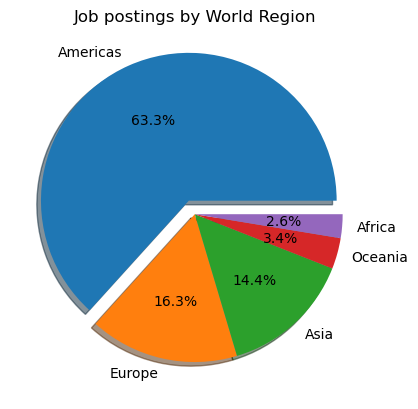

In [32]:
jobs_data_final_copy['region'].value_counts().plot(kind='pie',explode=(.1, 0, 0, 0,0),shadow=True,autopct='%1.1f%%',ylabel="",title="Job postings by World Region")
jobs_data_final_copy.head()

## Information Retrieval

In [33]:
# Initialize docker container
!powershell -command "docker compose down"
!powershell -command "docker compose up -d"
!powershell -command "docker cp web.xml pri23-24-solr-1:/opt/solr-9.3.0/server/solr-webapp/webapp/WEB-INF/web.xml"

 Container pri23-24-solr-1  Stopping
 Container pri23-24-solr-1  Stopped
 Container pri23-24-solr-1  Removing
 Container pri23-24-solr-1  Removed
 Network pri23-24_default  Removing
 Network pri23-24_default  Removed
 Network pri23-24_default  Creating
 Network pri23-24_default  Created
 Container pri23-24-solr-1  Creating
 Container pri23-24-solr-1  Created
 Container pri23-24-solr-1  Starting
 Container pri23-24-solr-1  Started


In [34]:
# Wait until solr is ready
import requests
import time

while True:
    try:
        response = requests.get('http://localhost:8983/solr')
        if response.status_code == 200:
            print('Solr is ready.')
            break
    except requests.exceptions.RequestException as e:
        print('Solr is not ready yet, waiting...')
        time.sleep(2)  # wait for 10 seconds before trying again

Solr is not ready yet, waiting...
Solr is ready.


### Schema

In [35]:
schema_path = 'solr/jobs_schema.json'

with open(schema_path, 'rb') as f:
    schema_data = f.read()

headers = {'Content-type': 'application/json'}

r = requests.post('http://localhost:8983/solr/jobs/schema', data=schema_data, headers=headers)

if r.status_code == 200:
    print('Schema updated successfully')
else:
    print('Error updating schema')
    print(r.text)

Schema updated successfully


### Insert data

In [36]:
import pysolr

solr = pysolr.Solr('http://localhost:8983/solr/jobs', timeout=10)

def convert_salary(row):
    if row['pay_period'] == 'YEARLY':
        return row['salary']
    elif row['pay_period'] == 'MONTHLY':
        return row['salary'] * 12
    elif row['pay_period'] == 'HOURLY':
        return row['salary'] * 1810
    else:
        return None

all_data = pd.merge(jobs_data, jobs_location_data, on='location_id', how='left')
all_data = pd.merge(all_data, company_data, on='company_id', how='left')
all_data.drop(columns=['location_id','company_id'],inplace=True)
all_data['yearly_salary'] = all_data.apply(lambda row: convert_salary(row), axis=1)
all_data_doc = all_data.to_dict(orient='records')

chunk_size = 2000  # adjust this value based on your needs

# Split data into chunks and add them to Solr
for i in range(0, len(all_data_doc), chunk_size):
    chunk = all_data_doc[i:i+chunk_size]
    solr.add(chunk)
    solr.commit()

### Query 1 - Administration jobs in education establishments

In [37]:
# Simple query
sq1 = solr.search(q='(company:university OR company:school OR company:college) AND (title:administration OR description:administration)', 
                sort='score desc', rows='10')

for hit in sq1:
    print(hit)

{'title': 'Postgraduate Administrator', 'work-type': 'Full-time', 'salary': 'NaN', 'description': 'Job description\n\nJob summary\n\nWe are seeking to recruit a Postgraduate Administrator to working directly with the Course Directors at Silwood Park, and other senior academic staff, you will primarily be responsible for the administration of postgraduate taught (PGT) activities on the Silwood Park Campus of the Department of Life Sciences.\n\nThe position is based at the Silwood Park Campus, which is home to approximately 25 academic staff, 40 research staff and 10 support staff. As well as housing state-of-the-art facilities for laboratory and field research, the campus is a recognised Centre for postgraduate training. You will be responsible for approximately 120 PGT students based at Silwood across 7 Masters Courses.\n\nThis is a busy and varied post requiring you to multi-task and to work to deadlines. You must be proactive in your approach to your duties and be able to work with m

In [38]:
# Boosting query
bq1 = solr.search(q='(company:university OR company:school OR company:college) AND (title:administration^4 OR description:administration)', 
                sort='score desc', rows='10')
for hit in bq1:
    print(hit)

{'title': 'Postgraduate Administrator', 'work-type': 'Full-time', 'salary': 'NaN', 'description': 'Job description\n\nJob summary\n\nWe are seeking to recruit a Postgraduate Administrator to working directly with the Course Directors at Silwood Park, and other senior academic staff, you will primarily be responsible for the administration of postgraduate taught (PGT) activities on the Silwood Park Campus of the Department of Life Sciences.\n\nThe position is based at the Silwood Park Campus, which is home to approximately 25 academic staff, 40 research staff and 10 support staff. As well as housing state-of-the-art facilities for laboratory and field research, the campus is a recognised Centre for postgraduate training. You will be responsible for approximately 120 PGT students based at Silwood across 7 Masters Courses.\n\nThis is a busy and varied post requiring you to multi-task and to work to deadlines. You must be proactive in your approach to your duties and be able to work with m

### Query 2 - Jobs as part of a team in medical field

In [39]:
# Simple query
sq2 = solr.search(q='(title:medical OR description:medical) AND (title:team OR description:team)', 
                sort='score desc', rows='10')

for hit in sq2:
    print(hit)

{'title': 'Medical Director, Medical Oncology', 'work-type': 'Full-time', 'salary': 'NaN', 'description': 'Unique leadership opportunity within an organization that is a well-recognized Commission on Cancer accredited institute. The organization is physician centered and in a strong financial position due to strength in leadership and culture. While the role will be located at the community hospital in the Western region of the US, the hospital has a relationship with a top Cancer Program in an Academic Medical Center through their community oncology partnership.\nThe local cancer program boasts a multidisciplinary team of experienced oncologists, surgeons, nurses, dedicated patient navigators, social workers, and other healthcare professionals who are committed to delivering compassionate and personalized care. The team works collaboratively to provide evidence-based treatment options, utilizing the latest advancements in cancer care to ensure the best possible outcomes for patients.\

In [40]:
# Boosting query
bq2 = solr.search(q='(title:medical^10 OR description:medical^5) AND (title:team OR description:team)', 
                sort='score desc', rows='10')

for hit in bq2:
    print(hit)

{'title': 'Medical Director, Medical Oncology', 'work-type': 'Full-time', 'salary': 'NaN', 'description': 'Unique leadership opportunity within an organization that is a well-recognized Commission on Cancer accredited institute. The organization is physician centered and in a strong financial position due to strength in leadership and culture. While the role will be located at the community hospital in the Western region of the US, the hospital has a relationship with a top Cancer Program in an Academic Medical Center through their community oncology partnership.\nThe local cancer program boasts a multidisciplinary team of experienced oncologists, surgeons, nurses, dedicated patient navigators, social workers, and other healthcare professionals who are committed to delivering compassionate and personalized care. The team works collaboratively to provide evidence-based treatment options, utilizing the latest advancements in cancer care to ensure the best possible outcomes for patients.\

### Query 3 - Data engineering jobs with 3 year experience required

In [41]:
# Simple query
sq3 = solr.search(q='(title:data description:data title:engineering description:engineering) AND description:"3 year experience"', 
                sort='score desc', rows='10')

for hit in sq3:
    print(hit)

{'title': 'Software Data Engineer (Scala/Python)', 'work-type': 'Full-time', 'salary': 'NaN', 'description': 'Software Data Engineer (Scala/Python) Hybrid on-site in Chicago, IL - local candidates or those willing to relocate only! Proprietary Trading Firm is looking to grow their data engineering organization with two engineers. Please see the details for both profiles below:  1. Software Engineer (Scala/Python)3+ years experience programming in Scala and/or Python Cloud data platform development and deployment using Infrastructure-as-CodeOperational dashboards to monitor data ingestion using Grafana, PrometheusOther technologies: GitLab, Bitbucket, Jenkins, RDS, S3 2. Software Engineer (Scala)3+ years experience programming in Python Large scale data platforms such a Spark, Kafka, Delta Lake Experience with ETL pipelines for batch and live streaming Other technologies: EKS/Kubernetes, MSK/Kafka, Spark, Databricks, Flink This is an opportunity to work at a data-driven organization in 

In [42]:
# Boosting query
bq3 = solr.search(q=' (title:data^5 description:data title:engineering^5 description:engineering) AND description:"3 year experience"~10', 
                sort='score desc', rows='10')

for hit in bq3:
    print(hit)

{'title': 'Data Engineer', 'work-type': 'Contract', 'salary': 'NaN', 'description': "Data Engineer | Hybrid| Contract Opportunity**Candidates should currently be in USA and be eligible to work in USA (H1B candidate) ****Candidates are required to work from the client location in Dallas, TX, USA (whichever is preferable to the candidate) twice a week**Hiring a Data Engineer for a premium client of ours.Job Responsibilities• Work closely with source data application teams and product owners to design, implement and support analytics solutions that provide insights to make better decisions• Implement data migration and data engineering solutions using Azure products and services: (Azure Data Lake Storage, Azure Data Factory, Azure Functions, Event Hub, Azure Stream Analytics, Azure Databricks, etc.) and traditional data warehouse tools.• Perform multiple aspects involved in the development lifecycle – design, cloud engineering (Infrastructure, network, security, and administration), inges

### Query 4 - Non-contract jobs, paid by hour, not computation related

In [43]:
# Simple query
sq4 = solr.search(q='(-work-type:Contract AND pay_period:HOURLY AND -title:computation AND -description:computation)', 
                sort='score desc', rows='10')

for hit in sq4:
    print(hit)

{'title': 'Registered Nurse (RN) Vaccinator', 'work-type': 'Part-time', 'salary': 'NaN', 'description': 'United Staffing Solutions is partnering with one of the biggest COVID vaccination clinics in the East Coast! We are currently hiring Registered Nurses (RN) to work as COVID vaccinators for either part-time or per diem. \nJob Details:Must be a licensed Registered Nurse in the state of MichiganHeadquarters - Muskegon, MichiganTraveling is required (vehicle will be provided by the company; travel hours are paid)Pay is $50/hourNo vaccination experience needed\nLimited slots only! If interested, please respond to this job post or you can directly reach out to me at shannel@unitedstaffing.com.', 'pay_period': 'HOURLY', 'city': ['Muskegon'], 'country': 'United States of America', 'region': 'Americas', 'company': ['United Staffing Solutions (USS)'], 'yearly_salary': ['NaN'], 'id': '8d1f23d1-2eae-4047-bb33-11d92cf44691', '_version_': 1785102892891373571}
{'title': 'Administrative Assistant',

In [44]:
# Boosting query
sq4 = solr.search(q='(-work-type:Contract AND pay_period:HOURLY^5 AND -title:computation AND -description:computation)', 
                sort='score desc', rows='10')

for hit in sq4:
    print(hit)

{'title': 'Registered Nurse (RN) Vaccinator', 'work-type': 'Part-time', 'salary': 'NaN', 'description': 'United Staffing Solutions is partnering with one of the biggest COVID vaccination clinics in the East Coast! We are currently hiring Registered Nurses (RN) to work as COVID vaccinators for either part-time or per diem. \nJob Details:Must be a licensed Registered Nurse in the state of MichiganHeadquarters - Muskegon, MichiganTraveling is required (vehicle will be provided by the company; travel hours are paid)Pay is $50/hourNo vaccination experience needed\nLimited slots only! If interested, please respond to this job post or you can directly reach out to me at shannel@unitedstaffing.com.', 'pay_period': 'HOURLY', 'city': ['Muskegon'], 'country': 'United States of America', 'region': 'Americas', 'company': ['United Staffing Solutions (USS)'], 'yearly_salary': ['NaN'], 'id': '8d1f23d1-2eae-4047-bb33-11d92cf44691', '_version_': 1785102892891373571}
{'title': 'Administrative Assistant',